# _*Pricing Iron Condor Option*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Stefan Woerner<sup>[1]</sup>, Daniel Egger<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ

### Introduction
<br>
Suppose a <a href="http://www.theoptionsguide.com/iron-condor.aspx">iron condor option</a> with strike prices $K_1 < K_2 < K_3 < K_4$ and an underlying asset whose spot price at maturity $S_T$ follows a given random distribution.
The corresponding payoff function is defined as:
<br>
<br>
$$ F(S_T) = 
\begin{cases}
0         ,& S_T < K_1 \\
S_T - K_1 ,& K_1 \leq S_T < K_2 \\
K_2 - K_1 ,& K_2 \leq S_T < K_3 \\
K_3 - S_T ,& K_3 \leq S_T < K_4 \\
0         ,& S_T \geq K_4. 
\end{cases}$$
<br>
In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price before discounting, for the option:
<br>
<br>
$$\mathbb{E}\left[ F(S_T) \right].$$
<br>
The approximation of the objective function is explained in detail in the following paper:<br>
<a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import BasicAer
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.components.uncertainty_models import LogNormalDistribution
from qiskit.aqua.components.uncertainty_problems import UnivariateProblem
from qiskit.aqua.components.uncertainty_problems import UnivariatePiecewiseLinearObjective as PwlObjective

### Uncertainty Model

We construct a circuit factory to load a log-normal random distribution into a quantum state.
The distribution is truncated to a given interval $[low, high]$ and discretized using $2^n$ grid points, where $n$ denotes the number of qubits used.
The unitary operator corresponding to the circuit factory implements the following: 
$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i}\big|i\rangle_{n},$$
where $p_i$ denote the probabilities corresponding to the truncated and discretized distribution and where $i$ is mapped to the right interval using the affine map:
$$ \{0, \ldots, 2^n-1\} \ni i \mapsto \frac{high - low}{2^n - 1} * i + low \in [low, high].$$

In [2]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0 # initial spot price
vol = 0.4 # volatility of 40%
r = 0.05 # annual interest rate of 4%
T = 40 / 365 # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma, low=low, high=high)

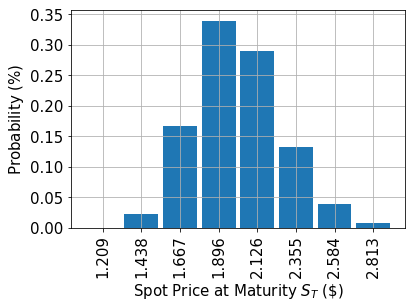

In [3]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

### Payoff Function

The payoff function equals zero as long as the spot price at maturity $S_T$ is less than the strike price $K_1$, then increases linearly, and is bounded by $K_2$.
The implementation uses two comparators, that flip an ancilla qubit each from $\big|0\rangle$ to $\big|1\rangle$ if $S_T \geq K_1$ and $S_T \leq K_2, and these ancillas are used to control the linear part of the payoff function.

The linear part itself is then approximated as follows.
We exploit the fact that $\sin^2(y + \pi/4) \approx y + 1/2$ for small $|y|$.
Thus, for a given approximation scaling factor $c_{approx} \in [0, 1]$ and $x \in [0, 1]$ we consider
$$ \sin^2( \pi/2 * c_{approx} * ( x - 1/2 ) + \pi/4) \approx \pi/2 * c_{approx} * ( x - 1/2 ) + 1/2 $$ for small $c_{approx}$.

We can easily construct an operator that acts as 
$$\big|x\rangle \big|0\rangle \mapsto \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right),$$
using controlled Y-rotations.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit, which corresponds to
$\sin^2(a*x+b)$.
Together with the approximation above, this allows to approximate the values of interest.
The smaller we choose $c_{approx}$, the better the approximation.
However, since we are then estimating a property scaled by $c_{approx}$, the number of evaluation qubits $m$ needs to be adjusted accordingly.

For more details on the approximation, we refer to:
<a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>

In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_1 = 1.438
strike_price_2 = 1.896
strike_price_3 = 2.126
strike_price_4 = strike_price_3 + strike_price_2 - strike_price_1

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [uncertainty_model.low, strike_price_1, strike_price_2, strike_price_3, strike_price_4]
slopes = [0, 1, 0, -1, 0]
offsets = [0, 0, strike_price_2 - strike_price_1, strike_price_2 - strike_price_1, 0]
f_min = 0
f_max = strike_price_2 - strike_price_1
iron_condor_objective = PwlObjective(
    uncertainty_model.num_target_qubits, 
    uncertainty_model.low, 
    uncertainty_model.high,
    breakpoints,
    slopes,
    offsets,
    f_min,
    f_max,
    c_approx
)

# construct circuit factory for payoff function
iron_condor = UnivariateProblem(
    uncertainty_model,
    iron_condor_objective
)

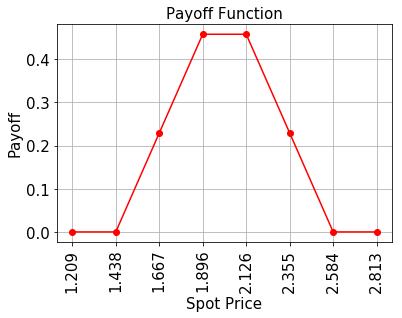

In [5]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
def payoff(x):
    if x <= strike_price_1:
        return 0
    elif x < strike_price_2:
        return x - strike_price_1
    elif x < strike_price_3:
        return strike_price_2 - strike_price_1
    elif x < strike_price_4:
        return strike_price_2 - strike_price_1 + strike_price_3 - x
    else:
        return 0
y = [payoff(x_) for x_ in x]
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
print('exact expected value:\t%.4f' % exact_value)

exact expected value:	0.3569


### Evaluate Expected Payoff

In [7]:
# set number of evaluation qubits (=log(samples))
m = 5

# construct amplitude estimation 
ae = AmplitudeEstimation(m, iron_condor)

In [8]:
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))

In [9]:
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % result['estimation'])
print('Probability:    \t%.4f' % result['max_probability'])

Exact value:    	0.3569
Estimated value:	0.3428
Probability:    	0.9697


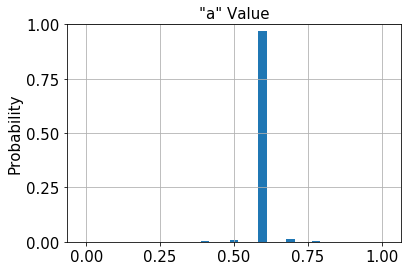

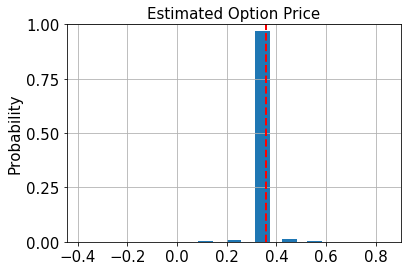

In [10]:
# plot estimated values for "a"
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price (after re-scaling and reversing the c_approx-transformation)
plt.bar(result['mapped_values'], result['probabilities'], width=1/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()